In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'

import torch
import numpy as np
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile
import pandas as pd

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn as nn
import random
from PIL import Image

In [3]:
DEVICE = 'cuda'
# DEVICE = torch.device("cuda:0,1,2" if torch.cuda.is_available() else "cpu")

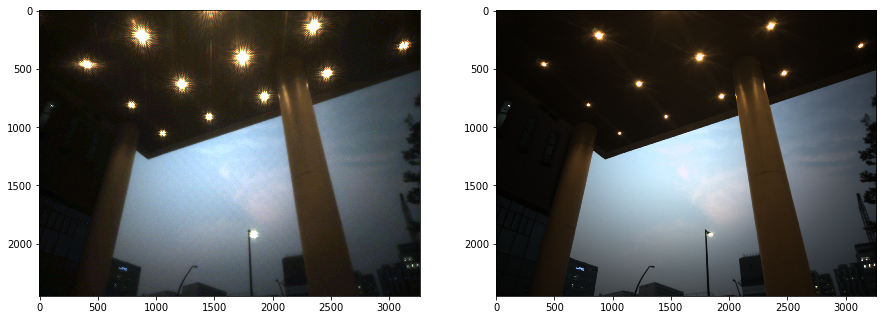

/home/ubuntu/Dacon2/train_input_img/train_input_10060.png /home/ubuntu/Dacon2/train_label_img/train_label_10060.png 



In [4]:
train_csv = pd.read_csv('/home/ubuntu/Dacon2/train.csv')
test_csv = pd.read_csv('/home/ubuntu/Dacon2/test.csv')

train_all_input_files = '/home/ubuntu/Dacon2/train_input_img/'+train_csv['input_img']
train_all_label_files = '/home/ubuntu/Dacon2/train_label_img/'+train_csv['label_img']
test_all_input_files = '/home/ubuntu/Dacon2/test_input_img/'+test_csv['input_img']

train_all_input_files[0], train_all_label_files[0], test_all_input_files[0]

train_input_files = train_all_input_files[60:].to_numpy()
train_label_files = train_all_label_files[60:].to_numpy()

val_input_files = train_all_input_files[:60].to_numpy()
val_label_files = train_all_label_files[:60].to_numpy()

test_input_files = test_all_input_files[:].to_numpy()

for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = cv2.imread(input_path)
    targ_img = cv2.imread(label_path)
    plt.figure(figsize=(15,10))
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(inp_img)
    plt.subplot(1,2,2)
    plt.imshow(targ_img)
    plt.show()
    print(input_path, label_path, '\n')
    break
    
BATCH_SIZE = 16
img_size = 256
#weights = None
weights = 'imagenet'
learning_rate = 1e-5
EPOCHS = 200
dropout_rate = 0.1

In [5]:
def cut_img(img_path_list, save_path, stride):
    os.makedirs(f'{save_path}{img_size}', exist_ok=True)
    num = 0
    for path in tqdm(img_path_list):
        img = cv2.imread(path)
        for top in range(0, img.shape[0], stride):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([img_size, img_size, 3], np.uint8)
                temp = img[top:top+img_size, left:left+img_size, :]
                piece[:temp.shape[0], :temp.shape[1], :] = temp
#                 np.save(f'{save_path}{img_size}/{num}.npy', piece)
                cv2.imwrite(f'{save_path}{img_size}/{num}.png',piece)
                num+=1
            

In [6]:
# cut_img(train_input_files, '/home/ubuntu/Dacon2/train_input_img_', 128)
# cut_img(train_label_files, '/home/ubuntu/Dacon2/train_label_img_', 128)
# cut_img(val_input_files, '/home/ubuntu/Dacon2/val_input_img_', 128)
# cut_img(val_label_files, '/home/ubuntu/Dacon2/val_label_img_', 128)
# cut_img(test_input_files, '/home/ubuntu/Dacon2/test_input_img_', 128)

In [7]:
train_inp_files = glob(f'/home/ubuntu/Dacon2/train_input_img_{img_size}/*.png')
train_targ_files = glob(f'/home/ubuntu/Dacon2/train_label_img_{img_size}/*.png')

val_inp_files = glob(f'/home/ubuntu/Dacon2/val_input_img_{img_size}/*.png')
val_targ_files = glob(f'/home/ubuntu/Dacon2/val_label_img_256/*.png')

In [8]:
test_inp_files = glob(f'/home/ubuntu/Dacon2/test_input_img_256/*.png')

In [9]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)

len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files), 

(0, 0, 0, 0)

In [10]:
len(test_inp_files)

0

# Dataset

In [11]:
path = '/home/ubuntu/Dacon2/'
train_input = np.array(sorted([y for x in os.walk('/home/ubuntu/Dacon2/train_input_img_256')
                         for y in glob(os.path.join(x[0], '*.png'))]))
train_label = np.array(sorted([y for x in os.walk('/home/ubuntu/Dacon2/train_label_img_256')
                         for y in glob(os.path.join(x[0], '*.png'))]))
valid_input = np.array(sorted([y for x in os.walk('/home/ubuntu/Dacon2/val_input_img_256')
                         for y in glob(os.path.join(x[0], '*.png'))]))
valid_label = np.array(sorted([y for x in os.walk('/home/ubuntu/Dacon2/val_label_img_256')
                         for y in glob(os.path.join(x[0], '*.png'))]))
test_input = np.array(sorted([y for x in os.walk('/home/ubuntu/Dacon2/test_inp_img_256/')
                         for y in glob(os.path.join(x[0], '*.png'))]))

In [12]:
len(train_input), len(train_label),len(valid_input), len(valid_label)

(0, 0, 0, 0)

In [13]:
class CustomDataset(Dataset):
    def __init__(self, data, label, w, h, is_train=True):
        self.data = data
        self.label = label
        self.w = w
        self.h = h
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, image, label):
        
        ## Resize
        resizer = T.Resize(size=(self.h, self.w))
        image = resizer(image)
        label = resizer(label)
        
        # Random Horizontal Flipping
        if random.random() > 0.5 and self.is_train:
            image = TF.hflip(image)
            label = TF.hflip(label)
            
        # Transform to tensor
        image = TF.to_tensor(image)
        label = TF.to_tensor(label)
        
        return image, label
    
    def __getitem__(self, idx):
        origin_img = Image.open(self.data[idx])
        label_img = Image.open(self.label[idx])
        
        if self.transform:
            origin_img, label_img = self.transform(origin_img, label_img)
        
        return origin_img, label_img

In [14]:
class TestDataset(Dataset):
    def __init__(self, data, w, h, is_train=True):
        
        self.data = test_input
        self.w = w
        self.h = h
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def transform(self, image):
        
        ## Resize
        resizer = T.Resize(size=(self.h, self.w))
        image = resizer(image)
        
        # Random Horizontal Flipping
        if random.random() > 0.5 and self.is_train:
            image = TF.hflip(image)
            
        # Transform to tensor
        image = TF.to_tensor(image)
        
        return image
    
    def __getitem__(self, idx):
        origin_img = Image.open(self.data[idx])
        
        if self.transform:
            origin_img = self.transform(origin_img)

        return origin_img

# Model

In [15]:
# !pip install segmentation_models_pytorch

In [16]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3
    )


In [17]:
import apex.parallel as parallel
import apex.amp as amp

In [18]:
# import torch.distributed as dist
# dist.init_process_group('gloo', init_method='file:///tmp/somefile', rank=0, world_size=1)

# model = nn.parallel.DistributedDataParallel(model)

# torch.cuda.set_device(DEVICE)
torch.distributed.init_process_group(backend='nccl',
                                     init_method='file:///tmp/somefile',
                                    rank=0,
                                    world_size=1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.cuda()
model, optimizer = amp.initialize(model, optimizer)
# model = parallel.DistributedDataParallel(model, delay_allreduce=True)
model = nn.DataParallel(model, device_ids=[0,1,2])



# preprocessing_fn = smp.encoders.get_preprocessing_fn('efficientnet-b1', pretrained='imagenet')

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [19]:
train_dataset = CustomDataset(data = train_input,
                                label = train_label,
                                w = 256,
                                h = 256)

valid_dataset = CustomDataset(data = valid_input,
                             label = valid_label,
                             w = 256,
                             h = 256)

test_dataset = TestDataset(data = test_input,
                          w = 256,
                          h = 256)

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True
                              ,num_workers=12, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False
                              ,num_workers=12, pin_memory=True)
test_dataloader = DataLoader(test_dataset)

In [21]:
criterion = nn.L1Loss()
# loss = nn.L1Loss()
# loss = smp.utils.losses.MOFLoss()

# metrics = [ smp.utils.metrics.Accuracy()]

def rmse_score(true, pred):
    score = math.sqrt(np.mean((true-pred)**2))
    return score

def psnr_score(true, pred, pixel_max):
    score = 20*np.log10(pixel_max/rmse_score(true, pred))
    return score

In [ ]:
## best_psnr = 0
for epoch in range(1, EPOCHS):
    train_running_step = len(train_dataloader)
    
    # Training Procedure
    print(f'runnnig step: {train_running_step}')
    avg_psnr = 0.0
    idx = 0
    model.train();
    for images, targets in tqdm(train_dataloader, total=len(train_dataloader)):
        
        images = images.type(torch.FloatTensor).to(DEVICE)
        targets = targets.type(torch.FloatTensor).to(DEVICE)
        
        optimizer.zero_grad()
        recons = model(images)
        recon_loss = criterion(nn.Sigmoid()(recons), targets)
        loss = recon_loss
        
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        
#         loss.backward()
        optimizer.step()
        
        psnr = psnr_score(targets.detach().cpu().numpy(), nn.Sigmoid()(recons).detach().cpu().numpy(), pixel_max=255.0)
        avg_psnr += psnr

        # Output training stats
        if (idx % int(train_running_step/10)) == 0:
            print(f'[{epoch}/{EPOCHS}], Loss: {loss.item()}' )
        idx += 1
        
    print(f'\t training psnr: {avg_psnr / train_running_step}')
#     res['train_psnr'].append(avg_psnr / train_running_step)
    
    val_running_step = len(valid_dataloader)
    print(f'runnnig step: {val_running_step}')
    
    torch.cuda.empty_cache()
    
    avg_psnr = 0.0
    idx = 0
    model.eval();
    for images, targets in tqdm(valid_dataloader, total=len(valid_dataloader)):
        images = images.type(torch.FloatTensor).to(DEVICE)
        targets = targets.type(torch.FloatTensor).to(DEVICE)
        
        val_recons = model(images)
        recon_loss = criterion(nn.Sigmoid()(val_recons), targets)
        loss = recon_loss
        
        score = psnr_score(targets.detach().cpu().numpy(), val_recons.detach().cpu().numpy(), pixel_max=255.0)
        avg_psnr += score
        
        if (idx % int(val_running_step/10)) == 0:
            print(f'[{epoch}/{EPOCHS}], Loss: {loss.item()}' )
        
        
#         if epoch % 2 == 0:
#             target_path = SAVE_IMAGE + str(epoch)+'/'
#             if not os.path.exists(target_path):
#                 os.makedirs(target_path, exist_ok=True)
                
#             grid = torchvision.utils.make_grid(tensor=torch.vstack([images,recons,targets]), nrow=images.shape[0])
#             torchvision.utils.save_image(grid, target_path+str(idx)+'.png')
        idx +=1
    torch.save(model, '/home/ubuntu/Dacon2/model/Best_Effi_UNet.pth')

In [23]:
test_inp_files = glob(f'/home/ubuntu/Dacon2/test_input_img/*.png')

In [24]:
test_input_nocut = np.array(sorted([y for x in os.walk('/home/ubuntu/Dacon2/test_input_img/')
                         for y in glob(os.path.join(x[0], '*.png'))]))

In [25]:
test_input_nocut

array(['/home/ubuntu/Dacon2/test_input_img/test_input_20000.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20001.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20002.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20003.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20004.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20005.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20006.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20007.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20008.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20009.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20010.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20011.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20012.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20013.png',
       '/home/ubuntu/Dacon2/test_input_img/test_input_20014.png',
       '/h

In [26]:
best_model = torch.load('/home/ubuntu/Dacon2/model/Best_Effi_UNet.pth')

In [27]:
patch_size = [512, 512]

best_model.eval()

with torch.no_grad():

    for idx, file_name in tqdm(enumerate(np.array(test_inp_files)), total=len(test_inp_files)):

        reference = T.ToTensor()(Image.open(file_name).resize((patch_size[0], patch_size[1]))).type(torch.FloatTensor).to(DEVICE)
        image = T.ToTensor()(Image.open(file_name))
        
        overlap = 1
        origin_HEIGHT = image.shape[1]
        origin_WIDTH  = image.shape[2]
        stride_h = patch_size[0] + overlap
        stride_w = patch_size[1] + overlap

        origin_size_image = torch.zeros((3, origin_HEIGHT + patch_size[0], origin_WIDTH+patch_size[1]))
        paded_image = torch.nn.functional.pad(input=image, pad=(0, patch_size[0], 0, patch_size[1]), mode='constant', value=0)

        for idx_h, height in enumerate(range(0, origin_HEIGHT, stride_h)):
            for idx_w, width in enumerate(range(0, origin_WIDTH, stride_w)):

                piece = paded_image[:, height:height+patch_size[0], width:width+patch_size[1]].type(torch.FloatTensor).to(DEVICE)
                reconstruction = nn.Sigmoid()(2))*255
                
                origin_size_image[:, height:height+patch_size[0], width:width+patch_size[1]] += reconstruction.squeeze(0).detach().cpu()

        save_img = origin_size_image.permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)[:origin_HEIGHT, :origin_WIDTH, :]
        save_path = '/home/ubuntu/Dacon2/sample_submission/test/'
        os.makedirs(save_path, exist_ok=True)
        cv2.imwrite(save_path+ file_name.split('/')[-1].replace("_input_", "_"), cv2.resize(save_img[:,:,::-1], (origin_WIDTH, origin_HEIGHT)))
#         submission = zipfile.ZipFile("submission.zip", 'w')
#         for path in save_img:
#             submission.write(save_path)
#         submission.close()

100%|██████████| 20/20 [00:54<00:00,  2.71s/it]


In [28]:

S = 3
w = 256
h = 256
batch_size = 16
results = []
def predict(test_dataloader):
    with torch.no_grad():
        for img in tqdm(test_dataloader):
            img = img.type(torch.FloatTensor)
            img = img/255
            crop = []
            position = []
            batch_count = 0

            result_img = np.zeros_like(img)
            voting_img = np.zeros_like(img)
            for top in tqdm(range(0, img.shape[0], 32)):
                for left in range(0, img.shape[1], 32):
                    piece = np.zeros([img_size, img_size,3], np.float32)
                    piece = torch.from_numpy(piece)
                    temp = img[top:top+img_size, left:left+img_size, :]
                    temp = temp.squeeze(0)
                    piece[:temp.shape[0], :temp.shape[1], :] = temp
                    crop.append(piece)
                    position.append([top,left])
                    batch_count += 1
                    if batch_count == batch_size:
                        crop = np.array(crop)
    #                     crop = torch.from_numpy(crop)
                        pred = best_model(crop)*255
                        crop = []
                        batch_count = 0
                        for num, (t, l) in enumerate(position):
                            piece = pred[num]
                            h, w, c = result_img[t:t+img_size, l:l+img_size, :].shape
                            result_img[t:t+img_size, l:l+img_size, :] += piece[:h, :w]
                            voting_mask[t:t+img_size, l:l+img_size, :] += 1
                        position = []

    #         result_img = result_img/voting_mask
#             cv2.imwrite('/home/user/Bae/Dacon2/data/test_20000'+str(batch_count)+'.png',result_img)
            result_img = result_img.astyp
    e(np.uint8)
            results.append(result_img)
        
        return results

IndentationError: unexpected indent (<ipython-input-28-de5cd2dd89ee>, line 45)